In [33]:
import rasterio
import glob
import geopandas as gpd
import pandas as pd

In [4]:
gdf_quadriculas_marcos = gpd.read_file('resultados/quadriculas_marcos.gpkg')

In [38]:
hs = []

for i, scm in gdf_quadriculas_marcos.iterrows():
    file_2017 = f'resultados/2017/MDT/MDT-{scm.qmdt_cod}-2017-50cm.tiff'
    file_2020 = f'resultados/2020/MDT/MDT-{scm.qmdt_cod}-2020-50cm.tiff'
    print(scm.qmdt_cod)

    # print(scm.apc_utm_e, scm.apc_utm_n)

    # abrindo arquivo e adquirindo o ponto
    dataset_2017 = rasterio.open(file_2017)
    h_2017 = list(dataset_2017.sample([[scm.apc_utm_e, scm.apc_utm_n]]))[0][0]


    dataset_2020 = rasterio.open(file_2020)
    h_2020 = list(dataset_2020.sample([[scm.apc_utm_e, scm.apc_utm_n]]))[0][0]

    # Atribuindo valor ao ponto

    h = {
        'scm': scm.qmdt_cod,
        'h_2017': h_2017,
        'h_2020': h_2020,
        'delta_2020_2017': h_2020 - h_2017
    }

    hs.append(h)

    # break

3212-343
3336-362
2346-361
3335-464
3335-354
2346-464
3212-132
3212-161
3211-261
3211-241
3213-122
3213-113
3213-153
3213-422
3213-443
3215-151
3215-253
3215-434
3215-442
3426-323
3425-454
3441-261
3431-153
2442-253
3441-423
2442-462
2441-461
3441-464
2442-363
2442-343
3443-211
3433-111
3443-261
3443-241
3434-162
3433-241
3433-161
2444-252
2444-152
2443-261
2444-244
3443-312
3434-322
3433-331
2444-311
3433-414
3443-461
3443-442
3434-451
2444-352
3433-354
3445-111
3436-122
3435-231
3445-223
3445-133
3435-113
2446-134
4436-152
3436-142
3445-431
3445-322
3436-311
3435-421
3435-312
2446-421
3445-433
3436-414
4436-361
3446-362
3435-352
4436-454
4435-464
4435-443
4435-344
3446-453
3446-453
3436-343
4312-221
3321-132
3312-232
3312-132
2322-232
4311-114
3322-123
3321-224
3311-223
4311-261
3322-251
3321-161
3312-151
3322-253
3311-143
4312-411
4312-331
3322-331
3322-312
4311-434
4311-334
4311-323
3312-433
3311-414
3322-461
3322-451
3312-441
3311-452
3311-361
4311-464
4311-344
3322-354
3321-454
3

In [51]:
gdf_validacao = pd.DataFrame(hs).set_index('scm').join(gdf_quadriculas_marcos.set_index('qmdt_cod'))

In [72]:
(gdf_validacao.h_2017 > 500).value_counts()

True     293
False      6
Name: h_2017, dtype: int64

In [52]:
gdf_validacao.columns

Index(['h_2017', 'h_2020', 'delta_2020_2017', 'index_right', 'apc_des_n',
       'apc_utm_e', 'apc_ponto', 'apc_ondula', 'apc_altort', 'apc_utm_n',
       'apc_altgeo', 'apc_des_e', 'apc_des_al', 'geometry'],
      dtype='object')

In [53]:
gdf_validacao.loc[:, 'diferenca_ortogonal_2017'] = gdf_validacao.loc[:, 'apc_altort'] - gdf_validacao.loc[:, 'h_2017']
gdf_validacao.loc[:, 'diferenca_ortogonal_2020'] = gdf_validacao.loc[:, 'apc_altort'] - gdf_validacao.loc[:, 'h_2020']

In [75]:
dif_2017_maior_1m = (gdf_validacao.loc[:, 'diferenca_ortogonal_2017'] > 10) | (gdf_validacao.loc[:, 'diferenca_ortogonal_2017'] < -10)
dif_2020_maior_1m = (gdf_validacao.loc[:, 'diferenca_ortogonal_2020'] > 10) | (gdf_validacao.loc[:, 'diferenca_ortogonal_2020'] < -10)
outliers = (dif_2017_maior_1m | dif_2020_maior_1m)
outliers.value_counts()

False    293
True       6
dtype: int64

In [100]:
gdf_validacao.loc[~outliers, ['diferenca_ortogonal_2017', 'diferenca_ortogonal_2020']].describe()

,diferenca_ortogonal_2017,diferenca_ortogonal_2020
count,293.000000,293.000000
mean,-0.019598,-0.008629
std,0.574536,0.547033
min,-5.024118,-4.151024
25%,-0.120221,-0.134452
50%,-0.063889,-0.079837
75%,0.017813,-0.031332
max,3.943336,3.946571


<AxesSubplot:ylabel='Density'>

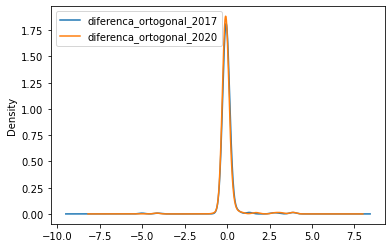

In [86]:
gdf_validacao.loc[~outliers, ['diferenca_ortogonal_2017', 'diferenca_ortogonal_2020']].plot.kde()

In [95]:
gpd.GeoDataFrame(gdf_validacao.drop(columns=['geometry']), geometry=gpd.points_from_xy(x=gdf_validacao.apc_utm_e, y=gdf_validacao.apc_utm_n)).reset_index().rename(columns={'index':'scm'}).to_file('resultados/validacao.gpkg', driver='GPKG')

/home/feromes/miniconda3/envs/geo/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
